# Gravity model, notes cited from professor Sobolevsky, NYU CUSP

### Results are shown at the end

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import networkx as nx
import time
import scipy.stats as stat
import statsmodels.formula.api as smf
from geopy.distance import vincenty

%pylab inline
import warnings
warnings.filterwarnings('ignore')
RootPath = '/Users/CQ/Documents/Project1'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


It is a common property for many spatial networks to have edge weight decay with distance (connections between more distant objects are weaker). This dependence is often thought as a power-law trend:
$$
e(a,b)\sim d(a,b)^{-\gamma}.
$$

However often nodes are not equal - for example in case of human mobility networks, where nodes are locations in space, while edges represent number of people moving between them, nodes might be of different size or different density. In this case one could also consider
$$
e(a,b)\sim w(a),\ e(a,b)\sim w(b),
$$
or more generally (keeping an idea of the power-law dependence and assuming under-/super-linear scaling of destination attractiveness or origin activity with size): 
$$
e(a,b)\sim w(a)^\alpha,\ e(a,b)\sim w(b)^\beta.
$$
where $w(x)$ is the weight of the node $x$. 

## General model

All together those relations lead to a model
$$
e(a,b)=k\cdot w(a) w(b) d(a,b)^{-\gamma},
$$
or more generally
$$
e(a,b)=k\cdot w(a)^\alpha w(b)^\beta d(a,b)^{-\gamma},
$$
where $k$ is the global proportionality (normalization) factor
$$
k=\frac{\sum\limits_{a,b}e(a,b)}{\sum\limits_{a,b} w(a)^\alpha w(b)^\beta d(a,b)^{-\gamma}}.
$$

In case network does not have loop edges to model, the normalization factor is defined as
$$
k=\frac{\sum\limits_{a\neq b}e(a,b)}{\sum\limits_{a\neq b} w(a)^\alpha w(b)^\beta d(a,b)^{-\gamma}}.
$$

Often it is reasonable to assume that $\alpha=\beta$ (especially if the network is symmetric, like representing number of people visiting both locations $a$ and $b$ regardless their order or cumulative communication flux between the two locations regardless directionality). 

This model is called gravity model.

## Gravity model with local normalization

Alternatively, one can also introduce local normalization, assuming relative scaling of strength of attractiveness of different destinations $b$ for the origin $a$ to be proportional to
$$
{\rm attr}_a(b)\sim w(b)^\beta d(a,b)^{-\gamma}.
$$
Given the known total outgoing strength $T(a)$ for each node $a$, this leads to the model
$$
e(a,b)=T(a) \frac{{\rm attr}_a(b)}{\sum_c {\rm attr}_a(c)}
$$
i.e.
$$
e(a,b)=T(a) \frac{w(b)^\beta d(a,b)^{-\gamma}}{\sum_c w(c)^\beta d(a,c)^{-\gamma}}.
$$
In case loop edges are missing in the network one should rather write
$$
e(a,b)=T(a) \frac{w(b)^\beta d(a,b)^{-\gamma}}{\sum_{c\neq a} w(c)^\beta d(a,c)^{-\gamma}},
$$
as the entire outgoing strenth is to be distributed among the possible non-loop edges for $c\neq a$. 

## Radiation model

Another alternative approach to modelling spatial networks of human mobility and potentially interactions has been suggested in a recent paper [Simini, F., González, M. C., Maritan, A., & Barabási, A. L. (2012). A universal model for mobility and migration patterns. Nature, 484(7392)]. The key idea is that people select a closet destination bettan than the one they have in their location of origin according to a certain attractiveness distribution and the beauty of the model is that it gives a one single paramter-free formulae (just based on the given population distribution, nothing to fit or assume unlike the exponents in the gravity model), no matter what the assumed attractiveness distribution was. The model however also relies on the knowledge of the cumulative outgoing strength of the nodes, just like the gravity model with the local normalization does.

The model predicting mobility flux (an edge) $e(a,b)$ between two locations $a,b$ is
$$
e(a,b)=T(a)\frac{p(a)p(b)}{\left(p(a)+s(a,b)\right)\left(p(a)+p(b)+s(a,b)\right)},
$$
where $p(a)$ denotes the population of the location $a$, while $s(a,b)$ is the total population enclosed in the circle centered in $a$ with the radius equal to $d(a,b)$ (i.e. the total population residing no further from $a$ compared to $b$).

In [3]:
twitter_file = pd.read_csv(RootPath + '/2016_02_18_sintetic.csv')
USzipcode = pd.read_csv(RootPath + '/USzipcode_XY.csv')
twitter_file.columns = ['Date','Time','ZipCode','User','ID']
USzipcode.columns = ['ZipCode','lat','lon']
twitter_file.Time = pd.to_datetime(twitter_file.Time, unit='s') - timedelta(hours=5) ## UTS - 5h NYC
twitter_file.Date = twitter_file.Time.dt.date

PLACES = twitter_file.ZipCode.unique()

start_date = twitter_file.iloc[0,0]
end_date = twitter_file.iloc[-1,0]
day_count = (end_date-start_date).days + 1
DateList = [start_date + timedelta(n) for n in range(day_count)]

def Clean_zipcode(dataset):
    zipcode_all = list(sorted(set(dataset.ZipCode)))
    zip_exist = [i for i in zipcode_all if i in USzipcode.ZipCode.values]
    return dataset[dataset.ZipCode.isin(zip_exist)]

Days = range(day_count)
for single_day in DateList:
    Days[DateList.index(single_day)] = twitter_file[twitter_file.Date == single_day]
    Days[DateList.index(single_day)] = Clean_zipcode(Days[DateList.index(single_day)])

Net1Day, Net2Day = range(day_count), range(day_count)
Net1GravDegree, Net2GravDegree = range(day_count), range(day_count)
Net1GravPageRk, Net2GravPageRk = range(day_count), range(day_count)
for i in range(day_count):
    Net1Day[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Naive/Original/Day %d of Twitter Data.csv'%(i+1), index_col=0)
    Net2Day[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Prob/Original/Day %d of Twitter Data.csv'%(i+1), index_col=0)
    Net1GravDegree[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Naive/DegCentrality/Day %d.csv'%(i+1), index_col=0)
    Net2GravDegree[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Prob/DegCentrality/Day %d.csv'%(i+1), index_col=0)
    Net1GravPageRk[i] = pd.read_csv(RootPath +'/GravModel/TimeSeries/Naive/PgRCentrality/Day %d.csv'%(i+1), index_col=0)
    Net2GravPageRk[i] = pd.read_csv(RootPath +'/GravModel/TimeSeries/Prob/PgRCentrality/Day %d.csv'%(i+1), index_col=0)

def LMOutput(model_index = 1, net_index = 1, centrality_index = 1, plot_index = 1, plot_action = False):
    '''
    This function outputs all lm.summary of our data, and the input arguments are
    model_index:
    1--log(weight)~log(distance) & log(weight) ~ log(distance)+log(tweet1)+log(tweet2) with all data
    2--Same lm but split data into two parts, one for training, one for validation
    net_index:
    1--naive network
    2--probabilistic network
    centrality_index:
    1--degree
    2--page rank
    plot_index
    1--plot log(weight)~log(distance)
    2--plot log(weight) ~ log(distance)+log(tweet1)+log(tweet2)
    '''
    LM1, LM2 = range(day_count), range(day_count)
    for i in range(day_count):
        if centrality_index == 1:
            data = Net1GravDegree[i].iloc[:,2:] if net_index == 1 else Net2GravDegree[i].iloc[:,2:]
        else:
            data = Net1GravPageRk[i].iloc[:,2:] if net_index == 1 else Net2GravPageRk[i].iloc[:,2:]
        missing_check = (data.distance > 0) & (data.weight > 0)
        data = data.loc[missing_check]
        if sum(missing_check) == 0:
            LM1[i], LM2[i] = False, False
        else:
            if model_index == 1:
                LM1[i] = smf.ols(formula='log(weight) ~ log(distance)', data = data).fit()
                LM2[i] = smf.ols(formula='log(weight) ~ log(distance)+log(tweet1)+log(tweet2)', data = data).fit()
            else:
                random.seed(2016)
                ind = stat.bernoulli.rvs(p = 0.75, size = len(data.weight))
                train = data.loc[ind == 1]
                valid = data.loc[ind == 0]
                LM1[i] = smf.ols(formula='log(weight) ~ log(distance)', data = train).fit()
                LM2[i] = smf.ols(formula='log(weight) ~ log(distance)+log(tweet1)+log(tweet2)', data = train).fit()
    index = [LM1.index(x) for x in LM1 if x]
    datelist = [DateList[i] for i in index]
    size = len(index)
    nrows = size/6 + ((size%6)!=0)
    ncols = 6    
    Title = 'Naive Network' if net_index ==1 else 'Probabilistic Network'
    if plot_action:
        fig = plt.figure(figsize=(20, 4*nrows))
        plt.suptitle(Title, fontweight="bold", size = 18)
    summary = []
    for i in range(size):
        if plot_action:
            plt.subplot(nrows, ncols, i+1)
        if centrality_index == 1:
            data = Net1GravDegree[index[i]].iloc[:,2:] if net_index == 1 else Net2GravDegree[index[i]].iloc[:,2:]
        else:
            data = Net1GravPageRk[index[i]].iloc[:,2:] if net_index == 1 else Net2GravPageRk[index[i]].iloc[:,2:]
        missing_check = (data.distance > 0) & (data.weight > 0)
        data = data.loc[missing_check]
        lm1 = LM1[index[i]]
        lm2 = LM2[index[i]]
        if model_index == 1:
            lme = lm1.predict(data) if plot_index == 1 else lm2.predict(data)
            if plot_action:
                plt.plot(lme,log(data.weight),'or')
                plt.plot(lme,lme,'-b')
                plt.title(datelist[i], fontweight='bold')
            a = [lm1.rsquared, lm1.params[0], lm1.params[1]]
            b = [lm2.rsquared, lm2.params[0], lm2.params[1], lm2.params[2], lm2.params[3]]
            c = a+b
            summary.append(c)
        else:
            lme = lm1.predict(valid) if plot_index == 1 else lm2.predict(valid)
            R2=1-sum(pow(log(valid.weight)-lme,2))/sum(pow(log(valid.weight)-mean(log(valid.weight)),2))
            if plot_action:
                plt.plot(lme,log(valid.weight),'or')
                plt.plot(lme,lme,'-b')
                R2=1-sum(pow(log(valid.weight)-lme,2))/sum(pow(log(valid.weight)-mean(log(valid.weight)),2))
                plt.title(datelist[i].strftime("%Y-%m-%d")+'\nValidation error=%f'%R2, fontweight='bold')
            a = [lm1.rsquared, lm1.params[0], lm1.params[1],R2]
            b = [lm2.rsquared, lm2.params[0], lm2.params[1], lm2.params[2], lm2.params[3],R2]
            c = a+b
            summary.append(c)
    a = 3 if model_index == 1 else 4
    model1 = ['log(weight) ~ log(dist)']*a
    b = 5 if model_index == 1 else 6
    model2 = ['log(weight) ~ log(dist)+log(tweet1)+log(tweet2)']*b
    line_1 = model1 + model2
    line_2 = ['R squared','Intercept_Coef','Dist_Coef','R squared','Intercept_Coef','Dist_Coef','Tweet1_Coef',
              'Tweet2_Coef'] if model_index == 1 else ['R squared','Intercept_Coef','Dist_Coef','Validation Error',
              'R squared','Intercept_Coef','Dist_Coef','Tweet1_Coef','Tweet2_Coef','Validation Error']
    arrays = [line_1, line_2]
    tuples = list(zip(*arrays))
    column = pd.MultiIndex.from_tuples(tuples, names=['Model', 'Parameters'])
    #fig.tight_layout()
    plt.subplots_adjust(top=0.95, hspace = 0.25)
    return pd.DataFrame(summary, index = datelist, columns = column)

DegNaive1 = LMOutput(1,1,1)
DegNaive2 = LMOutput(2,1,1)
DegProb1 = LMOutput(1,2,1)
DegProb2 = LMOutput(2,2,1)
PgRNaive1 = LMOutput(1,1,2)
PgRNaive2 = LMOutput(2,1,2)
PgRProb1 = LMOutput(1,2,2)
PgRProb2 = LMOutput(2,2,2)

In [82]:
def ConstructLine(x):
    '''
    This function is to fill in all missing value with 0
    x here is the "partition" or "dict" or simply a two-column dataframe indicating the 
    relationship between dates and its value, e.g. R^2 or Dist_Coefficients
    '''
    return [(x.index[i],x.values[i]) for i in range(len(x))]

In [83]:
LINE = range(8)
LINE[0] = ConstructLine(DegNaive1.iloc[:,5])
LINE[1] = ConstructLine(DegNaive2.iloc[:,6])
LINE[2] = ConstructLine(DegProb1.iloc[:,5])
LINE[3] = ConstructLine(DegProb2.iloc[:,6])

LINE[4] = ConstructLine(PgRNaive1.iloc[:,5])
LINE[5] = ConstructLine(PgRNaive2.iloc[:,6])
LINE[6] = ConstructLine(PgRProb1.iloc[:,5])
LINE[7] = ConstructLine(PgRProb2.iloc[:,6])

## Based on the value of $R^2$, our model needs some improvement if we want to use it to have better prediction of future data. However, if we only want to know whether the exponent of distance fluctuates over time, then the answer can be seen as follows:

## Below is the plot of exponent of DISTANCE, some notes:

### • For some days we don't have any data at all, and for those days we do, the majority of the users has only posted one single tweet, causing the graph having no "link" but only isolated "nodes", resulting in multiple days with value 0 as default, making the lines rather serrated than smooth. 
### • The general trend are pretty similar to each other, I guess it's because our model can't sufficiently demonstrate the variablity of the data ($R^2$ is somewhere between 0.05 to 0.4)
### • Despite the general trend, naive networks have much less variance than probabilistic networks if we take a closer look at the y-axis. The exponent in prob network is about 4 times large as its couterpart in naive network.

In [84]:
def ExponentPlot():
    CENT = ['Degree','Page Rank']
    MODEL = ['log(weight)~log(distance)','log(weight)~log(distance)+log(tweet1)+log(tweet2)']
    NET = ['Naive','Probabilistic']
    plt.figure(figsize=(20,20))
    Color = matplotlib.cm.spectral(np.linspace(0,1,8))
    for i in range(8):
        plt.subplot(811+i)
        plt.plot(zip(*LINE[i])[0], zip(*LINE[i])[1],c=Color[i], lw=3)
        plt.title(NET[(i/2)%2]+' Network with '+CENT[i/4]+' Centrality, '+MODEL[i%2], size = 18)
    plt.subplots_adjust(hspace=0.4)

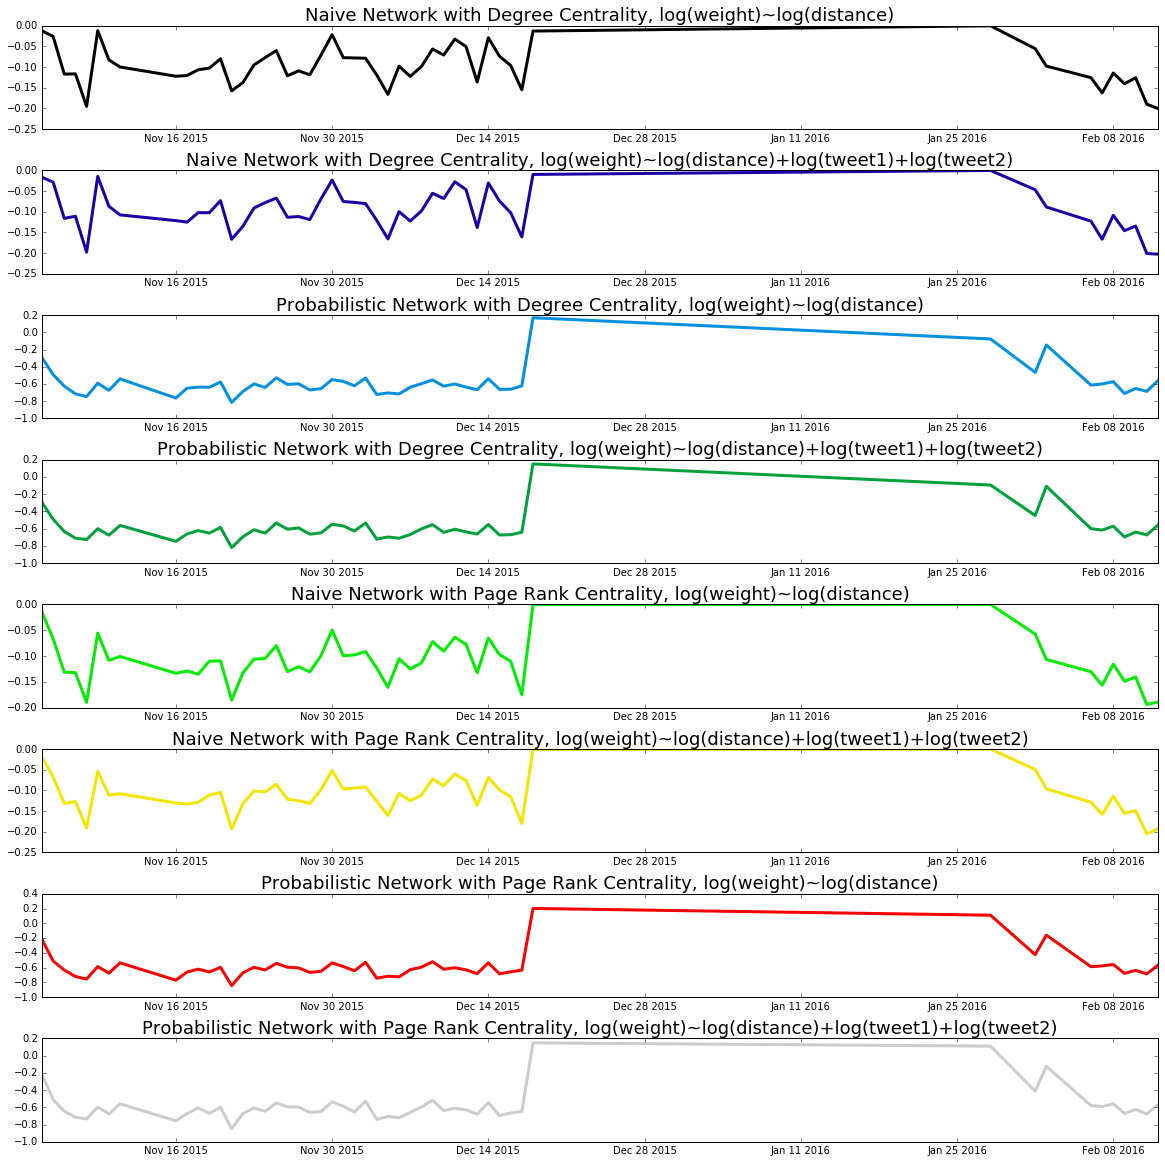

In [85]:
ExponentPlot()

### At the end we attach the summary of the parameters for each model, for potential reference

### Naive network, Degree Centrality

Model      log(weight) ~ log(dist)                                            \
Parameters               R squared Intercept_Coef Dist_Coef Validation Error   
2015-11-04                0.037281       0.066273 -0.027179        -0.281301   
2015-11-05                0.019847       0.781418 -0.102932        -0.137392   
2015-11-06                0.070814       0.874637 -0.196051        -0.051914   
2015-11-07                0.060263       0.919473 -0.187428        -0.132764   
2015-11-08                0.111485       0.891569 -0.265423         0.026166   
2015-11-09                0.014684       0.793643 -0.080575        -0.222594   
2015-11-10                0.051686       0.844593 -0.163256        -0.080096   
2015-11-11                0.073897       0.523814 -0.155979         0.067412   
2015-11-16                0.076795       0.723932 -0.184942         0.062557   
2015-11-17                0.075040       0.710758 -0.192692         0.073359   
2015-11-18                0.060891       0.814933 -0.187266        -0.001165   
2015-11-19                0.058335       0.765043 -0.166985         0.014439   
2015-11-20                0.043677       0.863765 -0.154668        -0.127598   
2015-11-21                0.109985       0.825054 -0.243848         0.052938   
2015-11-22                0.068384       0.918445 -0.210973        -0.079392   
2015-11-23                0.037286       0.745981 -0.143884        -0.004494   
2015-11-24                0.037552       0.722782 -0.138049         0.007183   
2015-11-25                0.030657       0.858744 -0.123758        -0.203992   
2015-11-26                0.044132       0.816825 -0.168877        -0.034326   
2015-11-27                0.062413       0.802137 -0.184914         0.007434   
2015-11-28                0.054787       0.868800 -0.179424        -0.077687   
2015-11-29                0.029589       0.738494 -0.129988        -0.021707   
2015-11-30                0.015392       0.734973 -0.085044        -0.117549   
2015-12-01                0.037918       0.724523 -0.140777         0.009967   
2015-12-02                0.045711       0.913208 -0.159862        -0.194533   
2015-12-03                0.039120       0.884285 -0.135926        -0.212903   
2015-12-04                0.062606       0.918791 -0.184109        -0.139773   
2015-12-05                0.087932       0.920382 -0.233973        -0.040149   
2015-12-06                0.045031       0.860365 -0.155109        -0.121382   
2015-12-07                0.063411       0.880923 -0.180213        -0.092562   
2015-12-08                0.051493       0.833933 -0.167402        -0.057580   
2015-12-09                0.026421       0.880829 -0.114200        -0.275018   
2015-12-10                0.037583       0.876833 -0.132929        -0.208562   
2015-12-11                0.018614       0.838896 -0.091869        -0.268634   
2015-12-12                0.023154       0.806969 -0.108298        -0.162144   
2015-12-13                0.065092       0.855547 -0.196460        -0.028746   
2015-12-14                0.017746       0.783407 -0.083697        -0.195418   
2015-12-15                0.047268       0.881899 -0.154028        -0.157732   
2015-12-16                0.056250       0.876107 -0.176357        -0.094369   
2015-12-17                0.117569       0.691876 -0.234117         0.081062   
2015-12-18                0.044139       0.034312 -0.026902        -0.342060   
2016-01-28                     NaN       0.000000  0.000000        -0.350274   
2016-02-01                0.071478       0.236593 -0.084569        -0.113098   
2016-02-02                0.095441       0.236143 -0.108411        -0.156615   
2016-02-06                0.076235       0.507216 -0.160409         0.057855   
2016-02-07                0.084210       0.702585 -0.208038         0.081588   
2016-02-08                0.046090       0.586499 -0.143951         0.077353   
2016-02-09                0.067630       0.670596 -0.183875         0.080277   


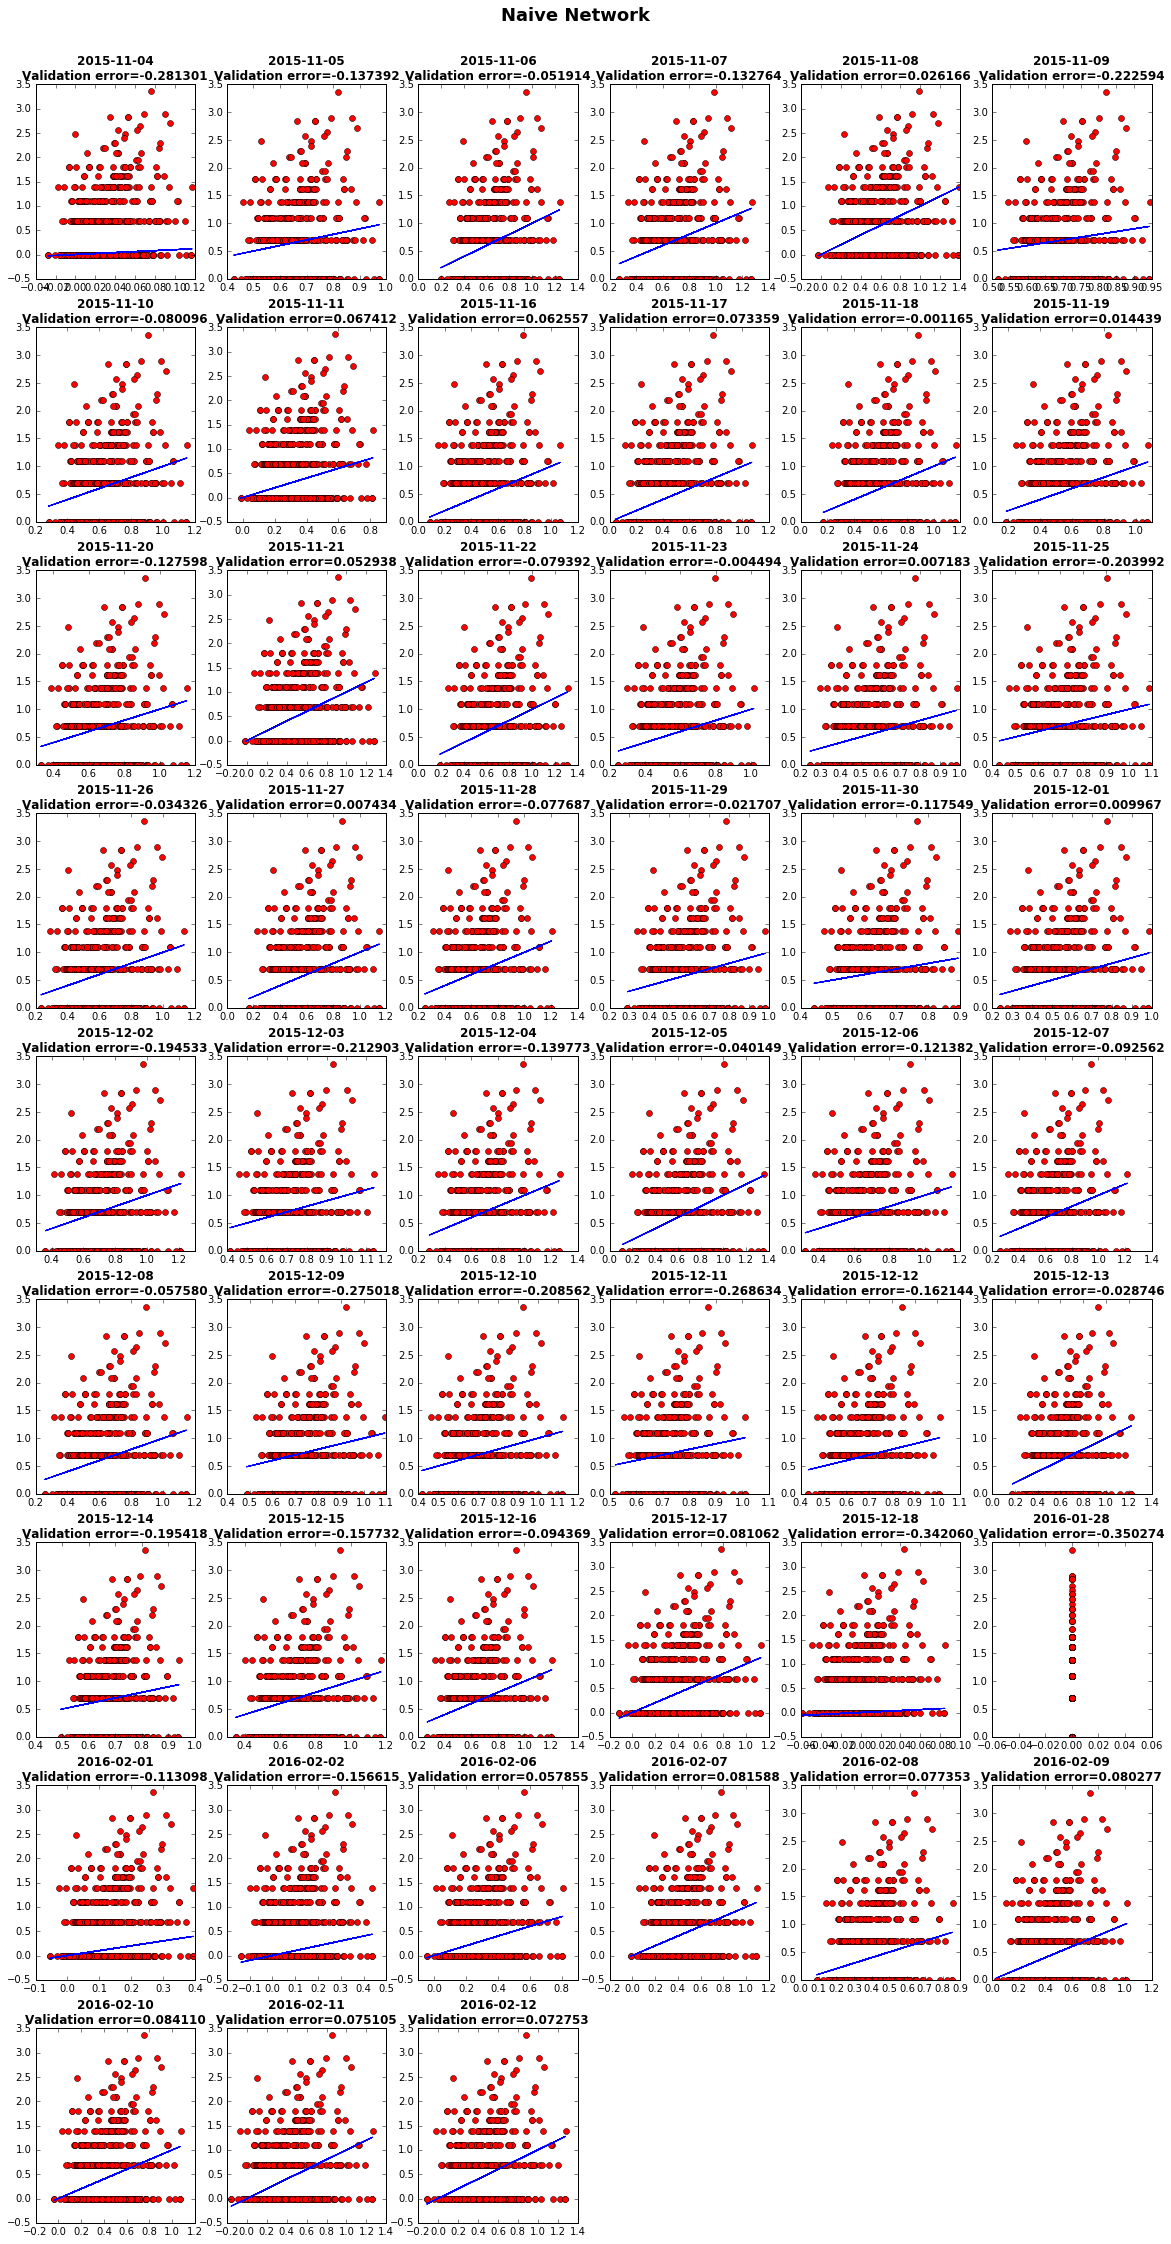

In [5]:
LMOutput(2,1,1,plot_action=True)

### Prob net, degree centrality
Some day we have unusual linear

Model      log(weight) ~ log(dist)                                            \
Parameters               R squared Intercept_Coef Dist_Coef Validation Error   
2015-11-04                0.082480      -7.721275 -0.240794        -2.543220   
2015-11-05                0.100805     -11.160111 -0.738183        -0.406075   
2015-11-06                0.149313     -10.666126 -0.907249        -0.245638   
2015-11-07                0.172831     -10.028351 -0.875634         0.060606   
2015-11-08                0.142656     -10.294319 -0.878309        -0.023936   
2015-11-09                0.147239     -10.537356 -0.826631        -0.092735   
2015-11-10                0.149715     -10.700935 -0.887903        -0.246991   
2015-11-11                0.156454      -9.781421 -0.688383         0.105894   
2015-11-16                0.191972      -9.998797 -0.987312         0.007310   
2015-11-17                0.139948     -10.772942 -0.883577        -0.290928   
2015-11-18                0.129779     -10.733196 -0.820596        -0.196260   
2015-11-19                0.150341     -10.675905 -0.876644        -0.218614   
2015-11-20                0.136239     -10.627250 -0.798736        -0.115151   
2015-11-21                0.210509     -10.104545 -1.003904        -0.041977   
2015-11-22                0.162702     -10.224852 -0.864356         0.010875   
2015-11-23                0.107796     -10.841252 -0.763715        -0.206347   
2015-11-24                0.139984     -10.531749 -0.802837        -0.070700   
2015-11-25                0.127567     -10.410597 -0.723035         0.029557   
2015-11-26                0.122486     -10.308380 -0.756217         0.044236   
2015-11-27                0.138082     -10.328010 -0.764067         0.034393   
2015-11-28                0.159583     -10.265551 -0.815411         0.026295   
2015-11-29                0.148524     -10.352963 -0.789410         0.012071   
2015-11-30                0.128955     -10.483018 -0.734025        -0.002021   
2015-12-01                0.120969     -10.733473 -0.751923        -0.131681   
2015-12-02                0.152514     -10.450277 -0.845781        -0.066472   
2015-12-03                0.129507     -10.547612 -0.749721        -0.038478   
2015-12-04                0.174270     -10.316186 -0.925182        -0.069074   
2015-12-05                0.166737     -10.199113 -0.901653        -0.004052   
2015-12-06                0.168812     -10.309033 -0.872283        -0.025509   
2015-12-07                0.149477     -10.449520 -0.840214        -0.061743   
2015-12-08                0.137638     -10.482897 -0.799424        -0.045815   
2015-12-09                0.117276     -10.711472 -0.767493        -0.133269   
2015-12-10                0.162389     -10.498191 -0.862231        -0.103392   
2015-12-11                0.155232     -10.502579 -0.872381        -0.114590   
2015-12-12                0.149991     -10.354393 -0.826369        -0.011695   
2015-12-13                0.147532     -10.292084 -0.836633         0.004742   
2015-12-14                0.130735     -10.705447 -0.761839        -0.125008   
2015-12-15                0.159195     -10.284993 -0.905604        -0.040110   
2015-12-16                0.154683     -10.308027 -0.860022        -0.016541   
2015-12-17                0.163431     -10.070206 -0.830906         0.070687   
2015-12-18                0.033004      -6.714138  0.137308        -6.279127   
2016-01-28                0.009176      -5.871956  0.079806        -8.537738   
2016-02-01                0.175856      -8.478795 -0.528041        -0.796857   
2016-02-02                0.025100      -8.587897 -0.165116        -1.380450   
2016-02-06                0.122613      -9.760213 -0.675071         0.101330   
2016-02-07                0.118342     -10.114325 -0.725173         0.097397   
2016-02-08                0.119295     -10.062471 -0.660369         0.112496   
2016-02-09                0.124321     -10.067938 -0.770321         0.092190   


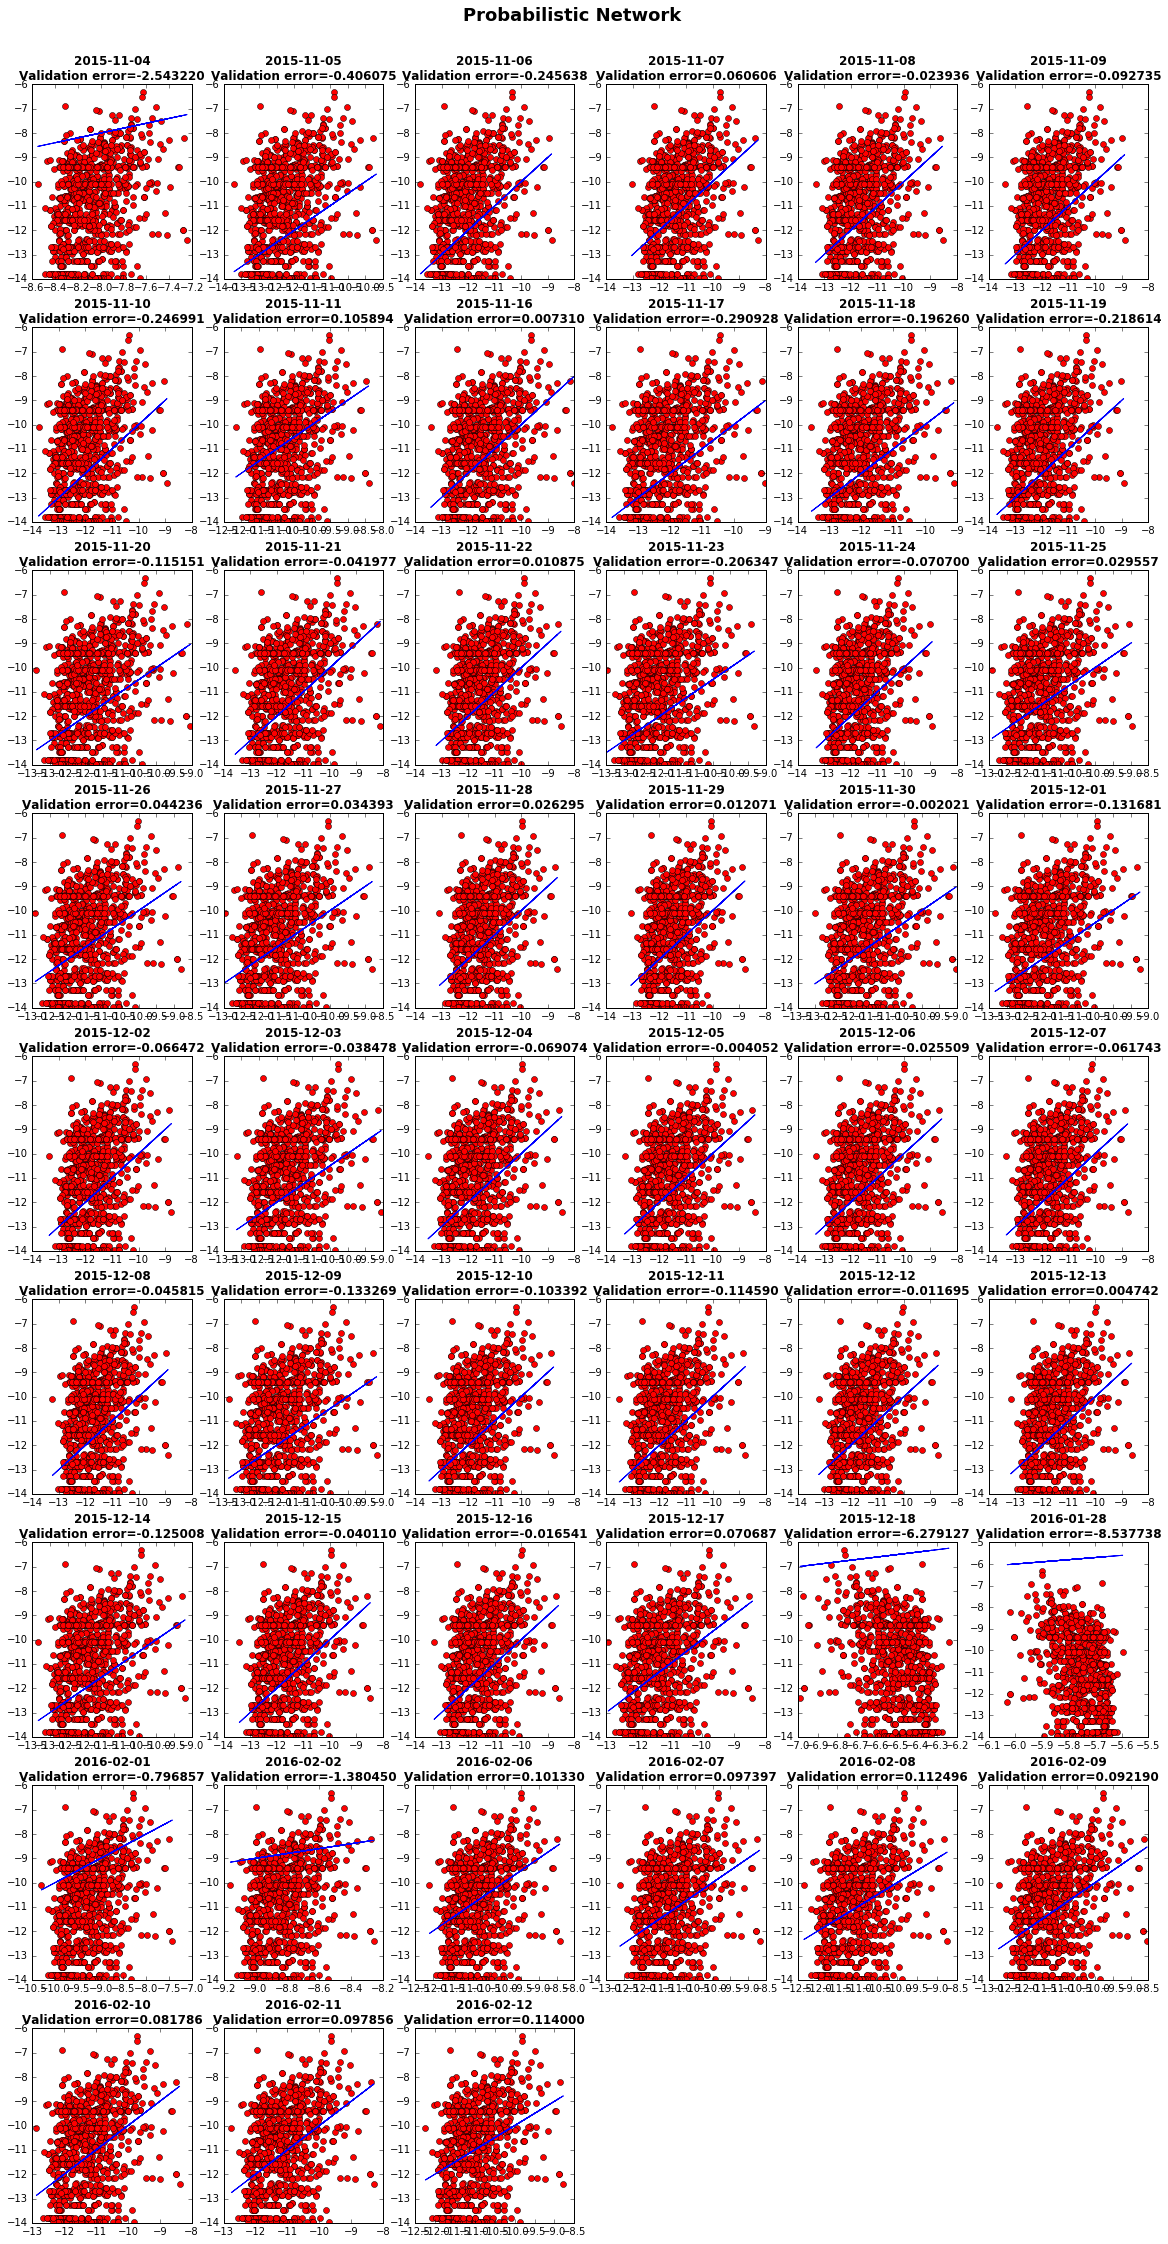

In [6]:
LMOutput(2,2,1,plot_action=True)

### Naive net, page rank centrality

In [7]:

PgRNaive1 = LMOutput(1,1,2)
PgRNaive2 = LMOutput(2,1,2)
PgRProb1 = LMOutput(1,2,2)
PgRProb2 = LMOutput(2,2,2)

### Prob net, page rank centrality

In [8]:
PgRProb2

Model      log(weight) ~ log(dist)                                            \
Parameters               R squared Intercept_Coef Dist_Coef Validation Error   
2015-11-04                0.082480      -7.721275 -0.240794        -2.543220   
2015-11-05                0.100805     -11.160111 -0.738183        -0.406075   
2015-11-06                0.149313     -10.666126 -0.907249        -0.245638   
2015-11-07                0.172831     -10.028351 -0.875634         0.060606   
2015-11-08                0.142656     -10.294319 -0.878309        -0.023936   
2015-11-09                0.147239     -10.537356 -0.826631        -0.092735   
2015-11-10                0.149715     -10.700935 -0.887903        -0.246991   
2015-11-11                0.156454      -9.781421 -0.688383         0.105894   
2015-11-16                0.191972      -9.998797 -0.987312         0.007310   
2015-11-17                0.139948     -10.772942 -0.883577        -0.290928   
2015-11-18                0.129779     -10.733196 -0.820596        -0.196260   
2015-11-19                0.150341     -10.675905 -0.876644        -0.218614   
2015-11-20                0.136239     -10.627250 -0.798736        -0.115151   
2015-11-21                0.210509     -10.104545 -1.003904        -0.041977   
2015-11-22                0.162702     -10.224852 -0.864356         0.010875   
2015-11-23                0.107796     -10.841252 -0.763715        -0.206347   
2015-11-24                0.139984     -10.531749 -0.802837        -0.070700   
2015-11-25                0.127567     -10.410597 -0.723035         0.029557   
2015-11-26                0.122486     -10.308380 -0.756217         0.044236   
2015-11-27                0.138082     -10.328010 -0.764067         0.034393   
2015-11-28                0.159583     -10.265551 -0.815411         0.026295   
2015-11-29                0.148524     -10.352963 -0.789410         0.012071   
2015-11-30                0.128955     -10.483018 -0.734025        -0.002021   
2015-12-01                0.120969     -10.733473 -0.751923        -0.131681   
2015-12-02                0.152514     -10.450277 -0.845781        -0.066472   
2015-12-03                0.129507     -10.547612 -0.749721        -0.038478   
2015-12-04                0.174270     -10.316186 -0.925182        -0.069074   
2015-12-05                0.166737     -10.199113 -0.901653        -0.004052   
2015-12-06                0.168812     -10.309033 -0.872283        -0.025509   
2015-12-07                0.149477     -10.449520 -0.840214        -0.061743   
2015-12-08                0.137638     -10.482897 -0.799424        -0.045815   
2015-12-09                0.117276     -10.711472 -0.767493        -0.133269   
2015-12-10                0.162389     -10.498191 -0.862231        -0.103392   
2015-12-11                0.155232     -10.502579 -0.872381        -0.114590   
2015-12-12                0.149991     -10.354393 -0.826369        -0.011695   
2015-12-13                0.147532     -10.292084 -0.836633         0.004742   
2015-12-14                0.130735     -10.705447 -0.761839        -0.125008   
2015-12-15                0.159195     -10.284993 -0.905604        -0.040110   
2015-12-16                0.154683     -10.308027 -0.860022        -0.016541   
2015-12-17                0.163431     -10.070206 -0.830906         0.070687   
2015-12-18                0.033004      -6.714138  0.137308        -6.279127   
2016-01-28                0.009176      -5.871956  0.079806        -8.537738   
2016-02-01                0.175856      -8.478795 -0.528041        -0.796857   
2016-02-02                0.025100      -8.587897 -0.165116        -1.380450   
2016-02-06                0.122613      -9.760213 -0.675071         0.101330   
2016-02-07                0.118342     -10.114325 -0.725173         0.097397   
2016-02-08                0.119295     -10.062471 -0.660369         0.112496   
2016-02-09                0.124321     -10.067938 -0.770321         0.092190   
